In [6]:
# 1. Preprocessing
# Steps for Preprocessing
#    Load and Clean Dataset:
#    Parse the NIH Chest X-ray metadata file.
#    Encode multi-label disease labels using MultiLabelBinarizer.
# 2.Data Augmentation (Optional for Training):
#   Use transformations like flipping, rotation, and zoom to improve generalization.
# 3.Normalize Images:
#   Resize all images to 224x224 and normalize pixel values to [0, 1].
# 4.Dataset Splits:
#   Use predefined splits (train_val_list.txt, test_list.txt) for consistency.

In [7]:
import tensorflow as tf

# Set memory growth for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tensorflow.keras import layers, models, optimizers, losses, callbacks
from tensorflow.keras.applications import Xception, DenseNet121

In [92]:
# load data
xray_data = pd.read_csv('/media/salman/New Volume/train_data/Data_Entry_2017.csv')
num_obs = len(xray_data)
print('Number of observations:',num_obs)

xray_data.head(10)

Number of observations: 92120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


Number of unique labels: 777
                                                    count
Finding Labels                                           
No Finding                                          49553
Infiltration                                         8099
Atelectasis                                          3491
Effusion                                             3139
Nodule                                               2259
...                                                   ...
Consolidation|Emphysema|Infiltration|Nodule             1
Pneumothorax|Infiltration                               1
Hernia|Infiltration|Nodule                              1
Cardiomegaly|Hernia|Mass                                1
Atelectasis|Effusion|Infiltration|Pneumonia|Pne...      1

[777 rows x 1 columns]


(<Axes: xlabel='Finding Labels', ylabel='Finding Labels'>,
 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [Text(0, 0, 'No Finding'),
   Text(1, 0, 'Infiltration'),
   Text(2, 0, 'Atelectasis'),
   Text(3, 0, 'Effusion'),
   Text(4, 0, 'Nodule'),
   Text(5, 0, 'Pneumothorax'),
   Text(6, 0, 'Mass'),
   Text(7, 0, 'Effusion|Infiltration'),
   Text(8, 0, 'Atelectasis|Infiltration'),
   Text(9, 0, 'Consolidation'),
   Text(10, 0, 'Atelectasis|Effusion'),
   Text(11, 0, 'Pleural_Thickening'),
   Text(12, 0, 'Cardiomegaly'),
   Text(13, 0, 'Emphysema'),
   Text(14, 0, 'Infiltration|Nodule'),
   Text(15, 0, 'Atelectasis|Effusion|Infiltration'),
   Text(16, 0, 'Fibrosis'),
   Text(17, 0, 'Edema'),
   Text(18, 0, 'Cardiomegaly|Effusion'),
   Text(19, 0, 'Effusion|Pneumothorax')]))

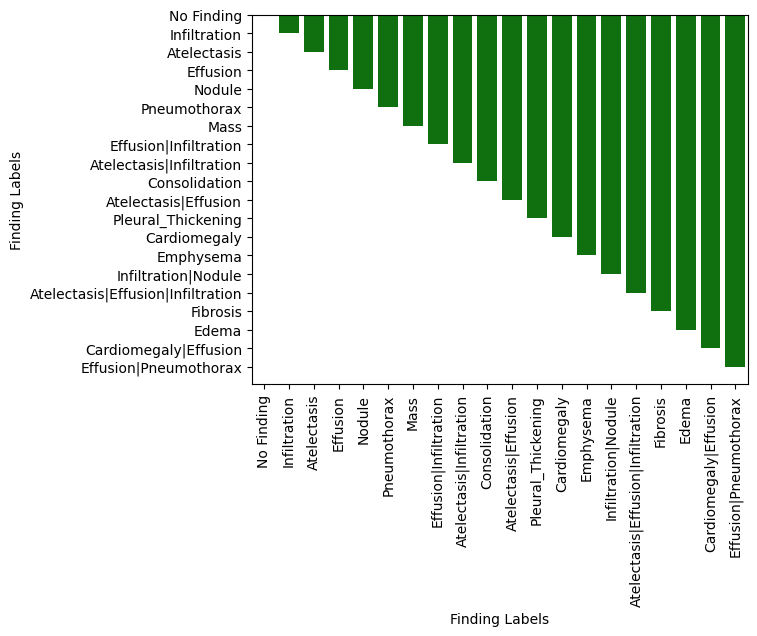

In [75]:
num_unique_labels = xray_data['Finding Labels'].nunique()
print('Number of unique labels:',num_unique_labels)

count_per_unique_label = xray_data['Finding Labels'].value_counts()
df_count_per_unique_label = count_per_unique_label.to_frame()

print(df_count_per_unique_label)
sns.barplot(x = df_count_per_unique_label.index[:20], y="Finding Labels", data=df_count_per_unique_label[:20], color = "green"), plt.xticks(rotation = 90)

In [8]:
# File paths
BASE_DIR = '/media/salman/New Volume/train_data'  # Update path
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
DATA_ENTRY_CSV = os.path.join(BASE_DIR, 'Data_Entry_2017.csv')
TRAIN_VAL_LIST = os.path.join(BASE_DIR, 'train_val_list.txt')
TEST_LIST = os.path.join(BASE_DIR, 'test_list.txt')

data_entry = pd.read_csv(DATA_ENTRY_CSV)
data_entry['Finding Labels'] = data_entry['Finding Labels'].str.split('|')

# Train/test split
def load_file_list(file_path):
    with open(file_path, 'r') as f:
        return [line.strip() for line in f.readlines()]

train_val_files = load_file_list(TRAIN_VAL_LIST)
test_files = load_file_list(TEST_LIST)

train_val_df = data_entry[data_entry['Image Index'].isin(train_val_files)]
test_df = data_entry[data_entry['Image Index'].isin(test_files)]

# Encode multi-labels
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
train_val_df['Labels'] = list(mlb.fit_transform(train_val_df['Finding Labels']))
test_df['Labels'] = list(mlb.transform(test_df['Finding Labels']))

# Train/validation split
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# Preprocess images
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess_image(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)  # Ensure RGB
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def create_dataset(df, augment=False):
    file_paths = [os.path.join(IMAGE_DIR, fname) for fname in df['Image Index']]
    labels = list(df['Labels'])
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y))
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Create datasets
train_ds = create_dataset(train_df, augment=True)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
train_val_df['Labels'] = list(mlb.fit_transform(train_val_df['Finding Labels']))
test_df['Labels'] = list(mlb.transform(test_df['Finding Labels']))

# Define num_classes
num_classes = len(mlb.classes_)
print("Number of classes:", num_classes)

Number of classes: 15


In [10]:
# 2. ResNet Implementation (From Scratch)
# Explanation:
#   The model uses residual blocks with skip connections.
#   Stages of residual blocks: (64, 128, 256, 512 filters).
#   Global average pooling is applied before the dense layer for classification.

In [25]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)

def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    for filters, blocks, stride in [(64, 2, 1), (128, 2, 2), (256, 2, 2), (512, 2, 2)]:
        for i in range(blocks):
            x = residual_block(x, filters, stride if i == 0 else 1)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    return models.Model(inputs, outputs)


In [12]:
# 3. Xception Finetuning
# Explanation:
#   Xception uses depthwise separable convolutions for efficiency.
#   Pre-trained on ImageNet; fine-tuned for our task.

In [29]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model  # Explicit import of Model
from tensorflow.keras.applications import Xception

def build_xception(num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the pre-trained layers
    x = layers.GlobalAveragePooling2D()(base_model.output)  # Pooling layer
    x = layers.Dense(512, activation='relu')(x)  # Dense layer
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # Output layer
    return Model(inputs=base_model.input, outputs=outputs)  # Explicitly use Model


model_xception = build_xception(num_classes)
model_xception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
# 4. DenseNet Finetuning
# Explanation:
#   DenseNet uses dense connections: each layer gets input from all preceding layers.
#   Pre-trained weights are fine-tuned.

In [31]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras.models import Model  # Explicitly import Model

def build_densenet(num_classes):
    # Load pre-trained DenseNet121 model without the top classification layer
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the pre-trained layers

    # Add new layers on top of the base model
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # Pooling layer
    x = layers.Dense(512, activation='relu')(x)  # Fully connected layer
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # Output layer for multi-label classification

    # Build the final model
    return Model(inputs=base_model.input, outputs=outputs)  # Explicitly use `Model`

# Build and compile the DenseNet model
model_densenet = build_densenet(num_classes)
model_densenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# 5. Training the Models

In [17]:
# Enable mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

BATCH_SIZE = 8
# Recreate datasets
train_ds = create_dataset(train_df, augment=True)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)

In [32]:
# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Compile and train all models
def train_model(model, name):
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)])
    history = model.fit(train_ds, validation_data=val_ds, epochs=34, callbacks=[early_stopping, lr_scheduler])
    model.save(f'{name}.keras')
    return history

history_resnet = train_model(build_resnet((224, 224, 3), num_classes), "ResNet")
history_xception = train_model(model_xception, "Xception")
history_densenet = train_model(model_densenet, "DenseNet")


Epoch 1/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:37 41ms/step - accuracy: 0.5679 - auc_1: 0.5809 - loss: 0.2054

2024-12-18 14:45:56.337589: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5695 - auc_1: 0.6075 - loss: 0.1981  

2024-12-18 14:48:32.917273: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1221', 8 bytes spill stores, 8 bytes spill loads

2024-12-18 14:48:42.564928: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 318s 43ms/step - accuracy: 0.5695 - auc_1: 0.6075 - loss: 0.1981 - val_accuracy: 0.5814 - val_auc_1: 0.6831 - val_loss: 0.1851 - learning_rate: 1.0000e-04
Epoch 2/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:37 41ms/step - accuracy: 0.5752 - auc_1: 0.6677 - loss: 0.1856

2024-12-18 14:51:08.716711: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7128/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5744 - auc_1: 0.6718 - loss: 0.1858  

2024-12-18 14:53:51.882516: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 307s 42ms/step - accuracy: 0.5744 - auc_1: 0.6718 - loss: 0.1858 - val_accuracy: 0.5772 - val_auc_1: 0.6912 - val_loss: 0.1853 - learning_rate: 1.0000e-04
Epoch 3/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5734 - auc_1: 0.6827 - loss: 0.1842

2024-12-18 14:56:16.392744: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5737 - auc_1: 0.6856 - loss: 0.1841  

2024-12-18 14:58:59.896564: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5737 - auc_1: 0.6856 - loss: 0.1841 - val_accuracy: 0.5824 - val_auc_1: 0.6972 - val_loss: 0.1831 - learning_rate: 1.0000e-04
Epoch 4/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:37 41ms/step - accuracy: 0.5748 - auc_1: 0.6947 - loss: 0.1830

2024-12-18 15:01:24.033831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5745 - auc_1: 0.6983 - loss: 0.1831  

2024-12-18 15:04:07.634174: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5745 - auc_1: 0.6983 - loss: 0.1831 - val_accuracy: 0.5790 - val_auc_1: 0.7029 - val_loss: 0.1835 - learning_rate: 1.0000e-04
Epoch 5/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5758 - auc_1: 0.7047 - loss: 0.1822

2024-12-18 15:06:32.287787: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5753 - auc_1: 0.7053 - loss: 0.1824  

2024-12-18 15:09:16.065626: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 43ms/step - accuracy: 0.5753 - auc_1: 0.7053 - loss: 0.1824 - val_accuracy: 0.5818 - val_auc_1: 0.7014 - val_loss: 0.1835 - learning_rate: 1.0000e-04
Epoch 6/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5764 - auc_1: 0.7052 - loss: 0.1822

2024-12-18 15:11:40.449389: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5762 - auc_1: 0.7083 - loss: 0.1821  

2024-12-18 15:14:23.986593: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5762 - auc_1: 0.7083 - loss: 0.1821 - val_accuracy: 0.5797 - val_auc_1: 0.7147 - val_loss: 0.1815 - learning_rate: 1.0000e-04
Epoch 7/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:37 41ms/step - accuracy: 0.5774 - auc_1: 0.7075 - loss: 0.1816

2024-12-18 15:16:48.184731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5762 - auc_1: 0.7126 - loss: 0.1815  

2024-12-18 15:19:31.431939: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 307s 42ms/step - accuracy: 0.5762 - auc_1: 0.7126 - loss: 0.1815 - val_accuracy: 0.5769 - val_auc_1: 0.7121 - val_loss: 0.1816 - learning_rate: 1.0000e-04
Epoch 8/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5812 - auc_1: 0.7156 - loss: 0.1804

2024-12-18 15:21:55.741073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5795 - auc_1: 0.7162 - loss: 0.1806  

2024-12-18 15:24:39.402902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5795 - auc_1: 0.7162 - loss: 0.1806 - val_accuracy: 0.5815 - val_auc_1: 0.7091 - val_loss: 0.1821 - learning_rate: 1.0000e-04
Epoch 9/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5783 - auc_1: 0.7193 - loss: 0.1800

2024-12-18 15:27:04.129470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5775 - auc_1: 0.7213 - loss: 0.1803  

2024-12-18 15:29:47.821501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 43ms/step - accuracy: 0.5775 - auc_1: 0.7213 - loss: 0.1803 - val_accuracy: 0.5821 - val_auc_1: 0.7124 - val_loss: 0.1817 - learning_rate: 1.0000e-04
Epoch 10/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5791 - auc_1: 0.7283 - loss: 0.1800

2024-12-18 15:32:12.450779: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5781 - auc_1: 0.7307 - loss: 0.1796  

2024-12-18 15:34:56.774573: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 309s 43ms/step - accuracy: 0.5781 - auc_1: 0.7307 - loss: 0.1796 - val_accuracy: 0.5801 - val_auc_1: 0.7105 - val_loss: 0.1814 - learning_rate: 5.0000e-05
Epoch 11/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5758 - auc_1: 0.7301 - loss: 0.1791

2024-12-18 15:37:21.151137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5767 - auc_1: 0.7324 - loss: 0.1789  

2024-12-18 15:40:05.066397: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 43ms/step - accuracy: 0.5767 - auc_1: 0.7324 - loss: 0.1789 - val_accuracy: 0.5814 - val_auc_1: 0.7163 - val_loss: 0.1820 - learning_rate: 5.0000e-05
Epoch 12/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5786 - auc_1: 0.7298 - loss: 0.1783

2024-12-18 15:42:29.478172: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5787 - auc_1: 0.7321 - loss: 0.1785  

2024-12-18 15:45:12.852169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5787 - auc_1: 0.7321 - loss: 0.1785 - val_accuracy: 0.5825 - val_auc_1: 0.7157 - val_loss: 0.1812 - learning_rate: 5.0000e-05
Epoch 13/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5817 - auc_1: 0.7347 - loss: 0.1777

2024-12-18 15:47:37.611327: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7124/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5803 - auc_1: 0.7379 - loss: 0.1780  

2024-12-18 15:50:21.265494: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 43ms/step - accuracy: 0.5803 - auc_1: 0.7379 - loss: 0.1780 - val_accuracy: 0.5806 - val_auc_1: 0.7185 - val_loss: 0.1812 - learning_rate: 5.0000e-05
Epoch 14/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:37 41ms/step - accuracy: 0.5791 - auc_1: 0.7379 - loss: 0.1774

2024-12-18 15:52:45.411240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5784 - auc_1: 0.7393 - loss: 0.1778  

2024-12-18 15:55:28.715765: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 307s 42ms/step - accuracy: 0.5784 - auc_1: 0.7393 - loss: 0.1778 - val_accuracy: 0.5814 - val_auc_1: 0.7172 - val_loss: 0.1813 - learning_rate: 5.0000e-05
Epoch 15/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5802 - auc_1: 0.7386 - loss: 0.1781

2024-12-18 15:57:53.300071: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5789 - auc_1: 0.7404 - loss: 0.1780  

2024-12-18 16:00:36.945682: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 43ms/step - accuracy: 0.5789 - auc_1: 0.7404 - loss: 0.1780 - val_accuracy: 0.5772 - val_auc_1: 0.7153 - val_loss: 0.1805 - learning_rate: 5.0000e-05
Epoch 16/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5781 - auc_1: 0.7422 - loss: 0.1779

2024-12-18 16:03:01.411995: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7130/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5785 - auc_1: 0.7437 - loss: 0.1777  

2024-12-18 16:05:45.098784: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 43ms/step - accuracy: 0.5785 - auc_1: 0.7437 - loss: 0.1777 - val_accuracy: 0.5810 - val_auc_1: 0.7164 - val_loss: 0.1814 - learning_rate: 5.0000e-05
Epoch 17/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5765 - auc_1: 0.7450 - loss: 0.1777

2024-12-18 16:08:09.574212: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7131/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5775 - auc_1: 0.7439 - loss: 0.1776  

2024-12-18 16:10:53.155196: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5775 - auc_1: 0.7439 - loss: 0.1776 - val_accuracy: 0.5807 - val_auc_1: 0.7137 - val_loss: 0.1821 - learning_rate: 5.0000e-05
Epoch 18/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:37 41ms/step - accuracy: 0.5816 - auc_1: 0.7372 - loss: 0.1768

2024-12-18 16:13:17.201731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5807 - auc_1: 0.7401 - loss: 0.1771  

2024-12-18 16:16:00.672468: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5807 - auc_1: 0.7401 - loss: 0.1771 - val_accuracy: 0.5828 - val_auc_1: 0.7169 - val_loss: 0.1813 - learning_rate: 5.0000e-05
Epoch 19/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5803 - auc_1: 0.7412 - loss: 0.1773

2024-12-18 16:18:24.902841: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5798 - auc_1: 0.7440 - loss: 0.1773  

2024-12-18 16:21:08.533292: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5798 - auc_1: 0.7440 - loss: 0.1773 - val_accuracy: 0.5809 - val_auc_1: 0.7152 - val_loss: 0.1804 - learning_rate: 2.5000e-05
Epoch 20/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5801 - auc_1: 0.7416 - loss: 0.1760

2024-12-18 16:23:32.805303: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7124/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5796 - auc_1: 0.7461 - loss: 0.1763  

2024-12-18 16:26:16.407352: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5796 - auc_1: 0.7461 - loss: 0.1763 - val_accuracy: 0.5813 - val_auc_1: 0.7190 - val_loss: 0.1809 - learning_rate: 2.5000e-05
Epoch 21/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5799 - auc_1: 0.7487 - loss: 0.1761

2024-12-18 16:28:40.650830: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7125/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5796 - auc_1: 0.7508 - loss: 0.1761  

2024-12-18 16:31:24.089292: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5796 - auc_1: 0.7508 - loss: 0.1761 - val_accuracy: 0.5821 - val_auc_1: 0.7191 - val_loss: 0.1809 - learning_rate: 2.5000e-05
Epoch 22/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5833 - auc_1: 0.7458 - loss: 0.1756

2024-12-18 16:33:48.485789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5821 - auc_1: 0.7490 - loss: 0.1759  

2024-12-18 16:36:31.889326: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5821 - auc_1: 0.7490 - loss: 0.1759 - val_accuracy: 0.5825 - val_auc_1: 0.7185 - val_loss: 0.1808 - learning_rate: 1.2500e-05
Epoch 23/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5810 - auc_1: 0.7514 - loss: 0.1753

2024-12-18 16:38:56.265158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7125/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5805 - auc_1: 0.7535 - loss: 0.1755  

2024-12-18 16:41:39.736001: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5805 - auc_1: 0.7535 - loss: 0.1755 - val_accuracy: 0.5811 - val_auc_1: 0.7211 - val_loss: 0.1799 - learning_rate: 1.2500e-05
Epoch 24/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5805 - auc_1: 0.7492 - loss: 0.1762

2024-12-18 16:44:04.088068: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5804 - auc_1: 0.7520 - loss: 0.1760  

2024-12-18 16:46:47.757163: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5804 - auc_1: 0.7520 - loss: 0.1760 - val_accuracy: 0.5818 - val_auc_1: 0.7200 - val_loss: 0.1805 - learning_rate: 1.2500e-05
Epoch 25/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5827 - auc_1: 0.7518 - loss: 0.1759

2024-12-18 16:49:12.191164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5816 - auc_1: 0.7521 - loss: 0.1759  

2024-12-18 16:51:55.896662: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5816 - auc_1: 0.7521 - loss: 0.1759 - val_accuracy: 0.5815 - val_auc_1: 0.7196 - val_loss: 0.1810 - learning_rate: 1.2500e-05
Epoch 26/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5820 - auc_1: 0.7498 - loss: 0.1759

2024-12-18 16:54:20.202867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7125/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5819 - auc_1: 0.7539 - loss: 0.1758  

2024-12-18 16:57:04.057072: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 43ms/step - accuracy: 0.5819 - auc_1: 0.7539 - loss: 0.1758 - val_accuracy: 0.5803 - val_auc_1: 0.7205 - val_loss: 0.1807 - learning_rate: 1.2500e-05
Epoch 27/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5826 - auc_1: 0.7544 - loss: 0.1751

2024-12-18 16:59:28.519392: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5810 - auc_1: 0.7567 - loss: 0.1753  

2024-12-18 17:02:11.934537: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5810 - auc_1: 0.7567 - loss: 0.1753 - val_accuracy: 0.5820 - val_auc_1: 0.7208 - val_loss: 0.1802 - learning_rate: 6.2500e-06
Epoch 28/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5840 - auc_1: 0.7563 - loss: 0.1750

2024-12-18 17:04:36.192625: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7130/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5827 - auc_1: 0.7576 - loss: 0.1754  

2024-12-18 17:07:19.407691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 308s 42ms/step - accuracy: 0.5827 - auc_1: 0.7576 - loss: 0.1754 - val_accuracy: 0.5817 - val_auc_1: 0.7204 - val_loss: 0.1803 - learning_rate: 6.2500e-06
Epoch 1/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5649 - auc_2: 0.5793 - loss: 0.2037

2024-12-18 17:09:57.430291: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5680 - auc_2: 0.6076 - loss: 0.1968  

2024-12-18 17:12:35.548598: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3691', 12 bytes spill stores, 12 bytes spill loads

2024-12-18 17:12:35.577243: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3691', 12 bytes spill stores, 12 bytes spill loads

2024-12-18 17:12:47.009910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 333s 44ms/step - accuracy: 0.5681 - auc_2: 0.6076 - loss: 0.1968 - val_accuracy: 0.5794 - val_auc_2: 0.6877 - val_loss: 0.1849 - learning_rate: 1.0000e-04
Epoch 2/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:37 41ms/step - accuracy: 0.5719 - auc_2: 0.6740 - loss: 0.1851

2024-12-18 17:15:17.201488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7126/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5730 - auc_2: 0.6779 - loss: 0.1849  

2024-12-18 17:18:01.506701: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 309s 43ms/step - accuracy: 0.5731 - auc_2: 0.6779 - loss: 0.1849 - val_accuracy: 0.5814 - val_auc_2: 0.6995 - val_loss: 0.1853 - learning_rate: 1.0000e-04
Epoch 3/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5744 - auc_2: 0.6954 - loss: 0.1831

2024-12-18 17:20:26.651444: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5742 - auc_2: 0.6975 - loss: 0.1830  

2024-12-18 17:23:11.056054: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5742 - auc_2: 0.6975 - loss: 0.1830 - val_accuracy: 0.5815 - val_auc_2: 0.7075 - val_loss: 0.1830 - learning_rate: 1.0000e-04
Epoch 4/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5740 - auc_2: 0.6999 - loss: 0.1818

2024-12-18 17:25:35.898113: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5741 - auc_2: 0.7045 - loss: 0.1819  

2024-12-18 17:28:20.085714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 309s 43ms/step - accuracy: 0.5741 - auc_2: 0.7045 - loss: 0.1819 - val_accuracy: 0.5793 - val_auc_2: 0.7135 - val_loss: 0.1813 - learning_rate: 1.0000e-04
Epoch 5/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5763 - auc_2: 0.7132 - loss: 0.1804

2024-12-18 17:30:45.169978: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7128/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5757 - auc_2: 0.7147 - loss: 0.1808  

2024-12-18 17:33:29.570599: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 309s 43ms/step - accuracy: 0.5757 - auc_2: 0.7147 - loss: 0.1808 - val_accuracy: 0.5689 - val_auc_2: 0.7175 - val_loss: 0.1804 - learning_rate: 1.0000e-04
Epoch 6/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5736 - auc_2: 0.7119 - loss: 0.1804

2024-12-18 17:35:54.520543: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7128/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5742 - auc_2: 0.7154 - loss: 0.1805  

2024-12-18 17:38:39.170848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5742 - auc_2: 0.7154 - loss: 0.1805 - val_accuracy: 0.5762 - val_auc_2: 0.7184 - val_loss: 0.1797 - learning_rate: 1.0000e-04
Epoch 7/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5769 - auc_2: 0.7205 - loss: 0.1804

2024-12-18 17:41:04.345643: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5768 - auc_2: 0.7229 - loss: 0.1804  

2024-12-18 17:43:48.738754: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 309s 43ms/step - accuracy: 0.5768 - auc_2: 0.7229 - loss: 0.1804 - val_accuracy: 0.5723 - val_auc_2: 0.7218 - val_loss: 0.1799 - learning_rate: 1.0000e-04
Epoch 8/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5778 - auc_2: 0.7236 - loss: 0.1790

2024-12-18 17:46:13.711900: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5766 - auc_2: 0.7256 - loss: 0.1795  

2024-12-18 17:48:57.851581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 309s 43ms/step - accuracy: 0.5766 - auc_2: 0.7256 - loss: 0.1795 - val_accuracy: 0.5818 - val_auc_2: 0.7245 - val_loss: 0.1805 - learning_rate: 1.0000e-04
Epoch 9/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5780 - auc_2: 0.7259 - loss: 0.1791

2024-12-18 17:51:22.796728: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5777 - auc_2: 0.7285 - loss: 0.1792  

2024-12-18 17:54:07.231691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5777 - auc_2: 0.7285 - loss: 0.1792 - val_accuracy: 0.5772 - val_auc_2: 0.7232 - val_loss: 0.1792 - learning_rate: 1.0000e-04
Epoch 10/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5811 - auc_2: 0.7230 - loss: 0.1789

2024-12-18 17:56:32.245216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7126/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5792 - auc_2: 0.7268 - loss: 0.1791  

2024-12-18 17:59:16.876186: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5792 - auc_2: 0.7268 - loss: 0.1791 - val_accuracy: 0.5809 - val_auc_2: 0.7226 - val_loss: 0.1797 - learning_rate: 1.0000e-04
Epoch 11/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5767 - auc_2: 0.7287 - loss: 0.1797

2024-12-18 18:01:42.061989: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7126/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5771 - auc_2: 0.7321 - loss: 0.1793  

2024-12-18 18:04:26.626417: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5771 - auc_2: 0.7321 - loss: 0.1793 - val_accuracy: 0.5727 - val_auc_2: 0.7351 - val_loss: 0.1793 - learning_rate: 1.0000e-04
Epoch 12/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5828 - auc_2: 0.7349 - loss: 0.1779

2024-12-18 18:06:51.504676: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7126/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5810 - auc_2: 0.7365 - loss: 0.1783  

2024-12-18 18:09:35.899304: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 309s 43ms/step - accuracy: 0.5810 - auc_2: 0.7365 - loss: 0.1783 - val_accuracy: 0.5744 - val_auc_2: 0.7301 - val_loss: 0.1790 - learning_rate: 1.0000e-04
Epoch 13/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5779 - auc_2: 0.7292 - loss: 0.1784

2024-12-18 18:12:01.292435: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5774 - auc_2: 0.7326 - loss: 0.1785  

2024-12-18 18:14:45.875229: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5774 - auc_2: 0.7326 - loss: 0.1785 - val_accuracy: 0.5827 - val_auc_2: 0.7296 - val_loss: 0.1791 - learning_rate: 1.0000e-04
Epoch 14/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5790 - auc_2: 0.7323 - loss: 0.1778

2024-12-18 18:17:11.243339: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5784 - auc_2: 0.7377 - loss: 0.1780  

2024-12-18 18:19:55.800361: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5784 - auc_2: 0.7377 - loss: 0.1780 - val_accuracy: 0.5817 - val_auc_2: 0.7298 - val_loss: 0.1817 - learning_rate: 1.0000e-04
Epoch 15/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5792 - auc_2: 0.7382 - loss: 0.1775

2024-12-18 18:22:20.972890: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7125/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5786 - auc_2: 0.7402 - loss: 0.1777  

2024-12-18 18:25:05.429623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5786 - auc_2: 0.7402 - loss: 0.1777 - val_accuracy: 0.5752 - val_auc_2: 0.7327 - val_loss: 0.1789 - learning_rate: 1.0000e-04
Epoch 16/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5771 - auc_2: 0.7464 - loss: 0.1765

2024-12-18 18:27:30.872914: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5769 - auc_2: 0.7487 - loss: 0.1768  

2024-12-18 18:30:15.638059: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5769 - auc_2: 0.7487 - loss: 0.1768 - val_accuracy: 0.5815 - val_auc_2: 0.7332 - val_loss: 0.1788 - learning_rate: 5.0000e-05
Epoch 17/34
3244/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5806 - auc_2: 0.7487 - loss: 0.1769

2024-12-18 18:32:40.556479: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5804 - auc_2: 0.7508 - loss: 0.1767  

2024-12-18 18:35:25.114535: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5804 - auc_2: 0.7508 - loss: 0.1767 - val_accuracy: 0.5771 - val_auc_2: 0.7358 - val_loss: 0.1783 - learning_rate: 5.0000e-05
Epoch 18/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5796 - auc_2: 0.7451 - loss: 0.1772

2024-12-18 18:37:50.416640: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7127/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5796 - auc_2: 0.7473 - loss: 0.1769  

2024-12-18 18:40:34.695189: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5796 - auc_2: 0.7473 - loss: 0.1769 - val_accuracy: 0.5809 - val_auc_2: 0.7324 - val_loss: 0.1799 - learning_rate: 5.0000e-05
Epoch 19/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5827 - auc_2: 0.7482 - loss: 0.1756

2024-12-18 18:42:59.870925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7128/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5812 - auc_2: 0.7502 - loss: 0.1761  

2024-12-18 18:45:44.580945: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5812 - auc_2: 0.7502 - loss: 0.1761 - val_accuracy: 0.5816 - val_auc_2: 0.7321 - val_loss: 0.1801 - learning_rate: 5.0000e-05
Epoch 20/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5802 - auc_2: 0.7493 - loss: 0.1757

2024-12-18 18:48:09.784001: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7129/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5801 - auc_2: 0.7521 - loss: 0.1759  

2024-12-18 18:50:53.879038: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 309s 43ms/step - accuracy: 0.5801 - auc_2: 0.7521 - loss: 0.1759 - val_accuracy: 0.5807 - val_auc_2: 0.7326 - val_loss: 0.1790 - learning_rate: 5.0000e-05
Epoch 21/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5814 - auc_2: 0.7556 - loss: 0.1755

2024-12-18 18:53:19.173012: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7128/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5808 - auc_2: 0.7573 - loss: 0.1756  

2024-12-18 18:56:03.448603: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5808 - auc_2: 0.7573 - loss: 0.1756 - val_accuracy: 0.5794 - val_auc_2: 0.7359 - val_loss: 0.1785 - learning_rate: 2.5000e-05
Epoch 22/34
3245/7132 ━━━━━━━━━━━━━━━━━━━━ 2:38 41ms/step - accuracy: 0.5801 - auc_2: 0.7541 - loss: 0.1750

2024-12-18 18:58:28.496554: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5805 - auc_2: 0.7566 - loss: 0.1752  

2024-12-18 19:01:13.048767: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - accuracy: 0.5805 - auc_2: 0.7566 - loss: 0.1752 - val_accuracy: 0.5802 - val_auc_2: 0.7354 - val_loss: 0.1783 - learning_rate: 2.5000e-05


In [72]:
# Log training metrics for each model
log_training_metrics(history_resnet.history, "ResNet", auc_metric_key="auc")
log_training_metrics(history_xception.history, "Xception", auc_metric_key="auc_1")
log_training_metrics(history_densenet.history, "DenseNet", auc_metric_key="auc_2")



Training Metrics for ResNet:

Epoch 1/26 ━━━━━━━━━━━━━━━━ accuracy: 0.5749 - auc: 0.5948 - loss: 0.1953 - val_accuracy: 0.5823 - val_auc: 0.6229 - val_loss: 0.1959
Epoch 2/26 ━━━━━━━━━━━━━━━━ accuracy: 0.5751 - auc: 0.6234 - loss: 0.1917 - val_accuracy: 0.5643 - val_auc: 0.6062 - val_loss: 0.1995
Epoch 3/26 ━━━━━━━━━━━━━━━━ accuracy: 0.5743 - auc: 0.6479 - loss: 0.1889 - val_accuracy: 0.5804 - val_auc: 0.6346 - val_loss: 0.1982
Epoch 4/26 ━━━━━━━━━━━━━━━━ accuracy: 0.5762 - auc: 0.6640 - loss: 0.1869 - val_accuracy: 0.5801 - val_auc: 0.6629 - val_loss: 0.1917
Epoch 5/26 ━━━━━━━━━━━━━━━━ accuracy: 0.5765 - auc: 0.6732 - loss: 0.1853 - val_accuracy: 0.5822 - val_auc: 0.6529 - val_loss: 0.1973
Epoch 6/26 ━━━━━━━━━━━━━━━━ accuracy: 0.5761 - auc: 0.6798 - loss: 0.1844 - val_accuracy: 0.5689 - val_auc: 0.6833 - val_loss: 0.1883
Epoch 7/26 ━━━━━━━━━━━━━━━━ accuracy: 0.5762 - auc: 0.6894 - loss: 0.1832 - val_accuracy: 0.5622 - val_auc: 0.6847 - val_loss: 0.1933
Epoch 8/26 ━━━━━━━━━━━━━━━━ acc

In [4]:
from tensorflow.keras.models import load_model
# Load the saved models
resnet_model = load_model('ResNet.keras')
xception_model = load_model('Xception.keras')
densenet_model = load_model('DenseNet.keras')

print("Models loaded successfully!")

Models loaded successfully!


In [36]:
import pickle

# Function to save the history
def save_history(history, filename):
    with open(filename, 'wb') as file:
        pickle.dump(history.history, file)
    print(f"Training history saved to {filename}")

# Save each model's history
save_history(history_resnet, "resnet_history.pkl")
save_history(history_xception, "xception_history.pkl")
save_history(history_densenet, "densenet_history.pkl")


Training history saved to resnet_history.pkl
Training history saved to xception_history.pkl
Training history saved to densenet_history.pkl


In [ ]:
# Function to load the history
def load_history(filename):
    with open(filename, 'rb') as file:
        history = pickle.load(file)
    print(f"Training history loaded from {filename}")
    return history

# Load saved histories
loaded_resnet_history = load_history("resnet_history.pkl")
loaded_xception_history = load_history("xception_history.pkl")
loaded_densenet_history = load_history("densenet_history.pkl")


In [23]:
import tensorflow as tf
import os
import numpy as np

IMG_SIZE = 224

def preprocess_image_for_inference(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)  # Ensure 3 channels (RGB)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Resize to 224x224
    img = img / 255.0  # Normalize to [0, 1]
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img


In [71]:
def log_training_metrics(history, model_name, auc_metric_key="auc"):

    print(f"\nTraining Metrics for {model_name}:\n")
    epochs = len(history['accuracy'])
    
    for epoch in range(epochs):
        print(
            f"Epoch {epoch + 1}/{epochs} ━━━━━━━━━━━━━━━━ "
            f"accuracy: {history['accuracy'][epoch]:.4f} - "
            f"{auc_metric_key}: {history[auc_metric_key][epoch]:.4f} - "
            f"loss: {history['loss'][epoch]:.4f} - "
            f"val_accuracy: {history['val_accuracy'][epoch]:.4f} - "
            f"val_{auc_metric_key}: {history[f'val_{auc_metric_key}'][epoch]:.4f} - "
            f"val_loss: {history['val_loss'][epoch]:.4f}"
        )


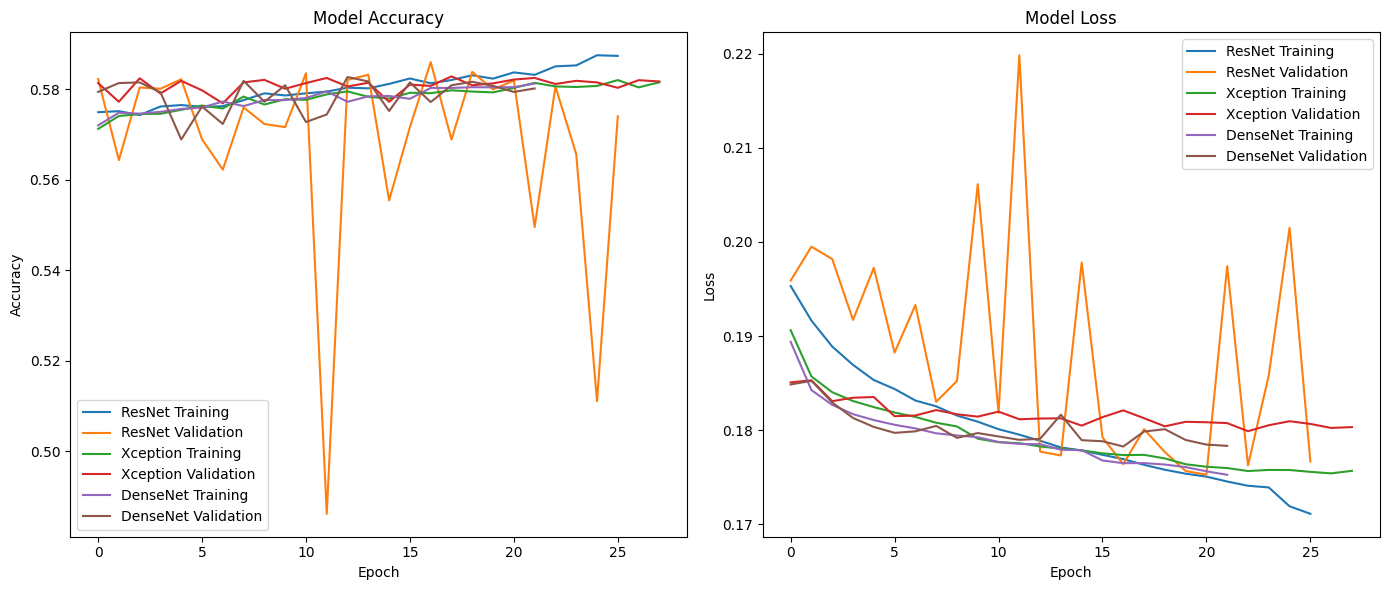


Evaluating ResNet...


2024-12-18 20:15:14.035480: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


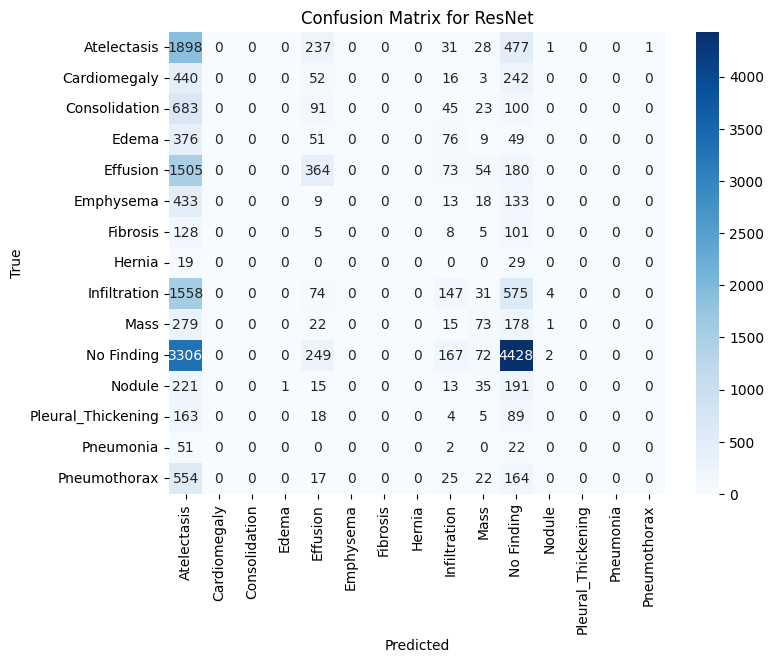

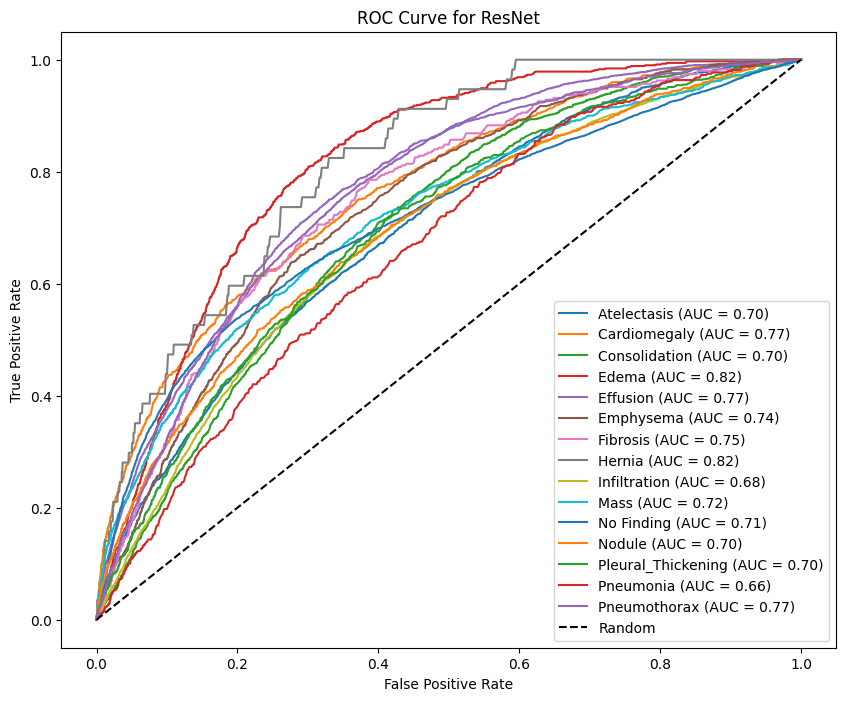


Evaluating Xception...


2024-12-18 20:17:22.665565: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1172', 8 bytes spill stores, 8 bytes spill loads

2024-12-18 20:17:24.651928: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


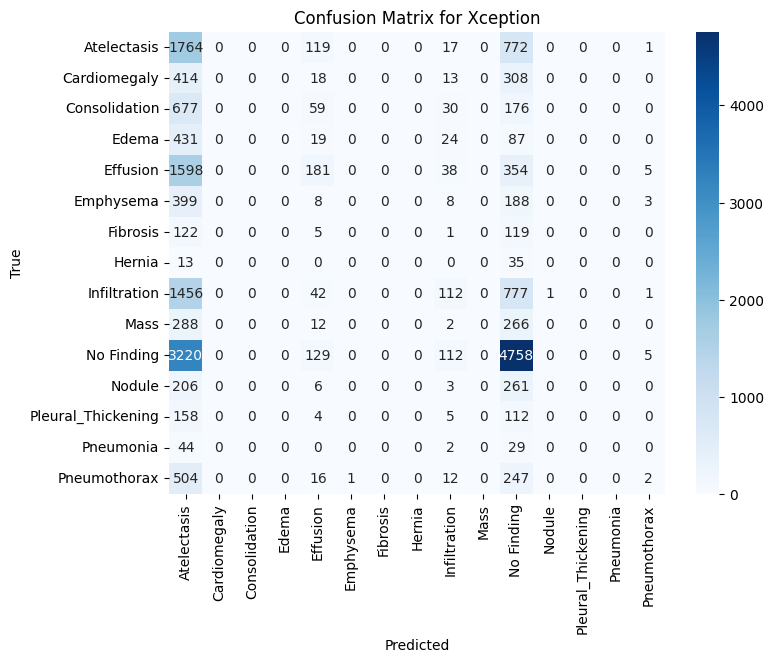

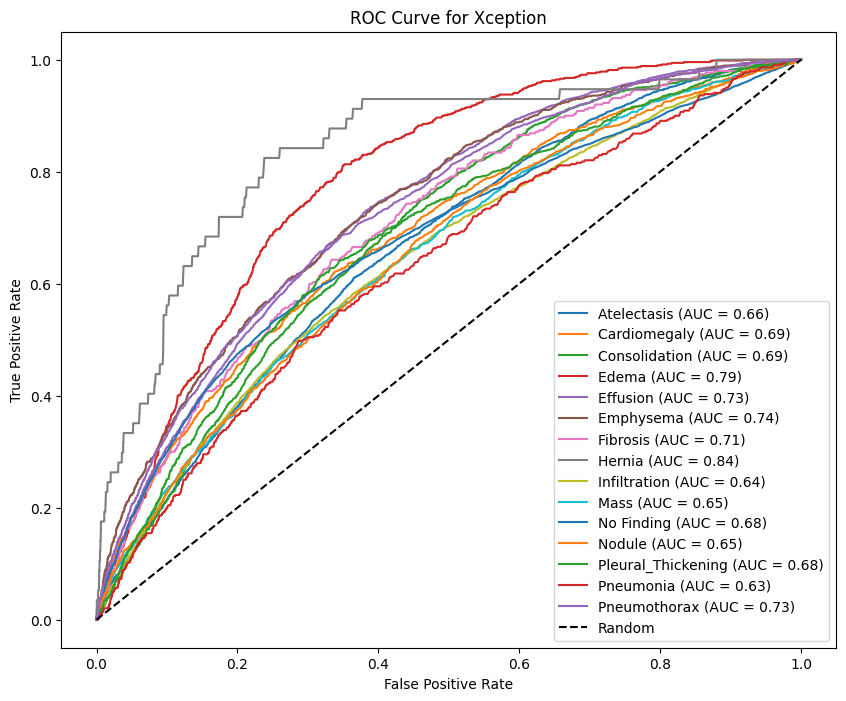


Evaluating DenseNet...


2024-12-18 20:19:39.416491: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3642', 12 bytes spill stores, 12 bytes spill loads

2024-12-18 20:19:39.454597: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3642', 12 bytes spill stores, 12 bytes spill loads



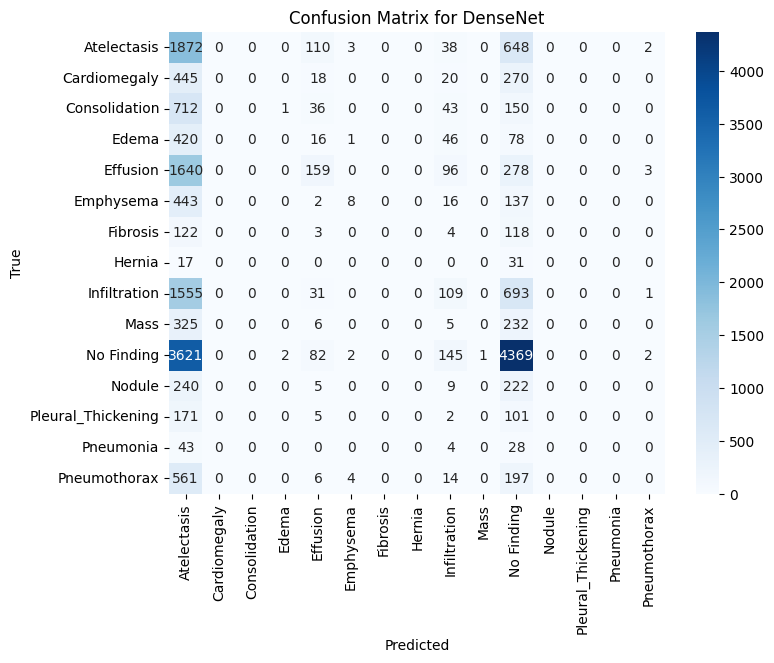

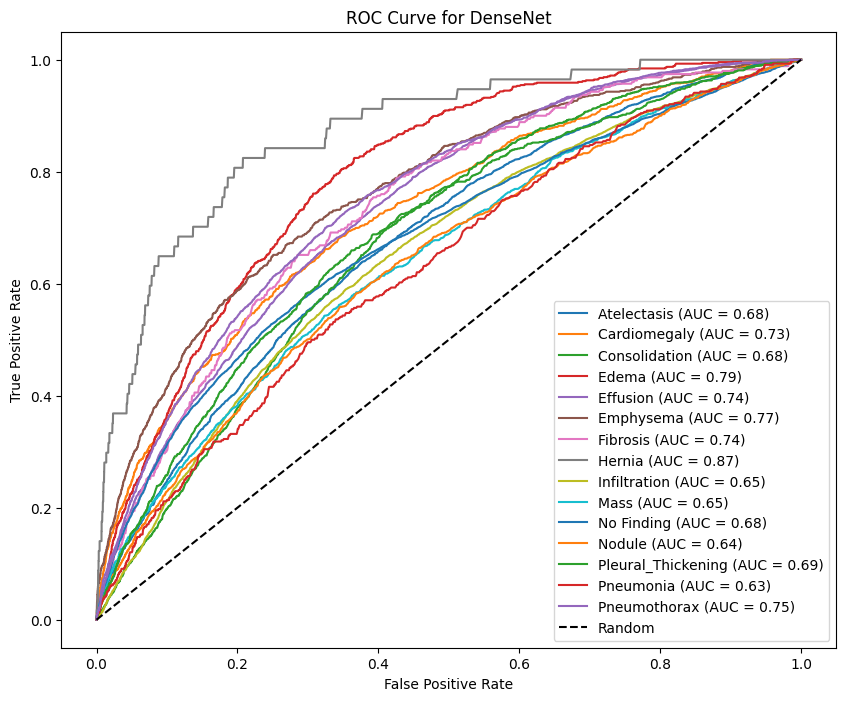


Model Performance Comparison:
      Model  Precision    Recall  F1-Score       AUC
0    ResNet   0.183226  0.069509  0.091200  0.733569
1  Xception   0.147333  0.047443  0.053643  0.700870
2  DenseNet   0.190760  0.045411  0.054889  0.712083


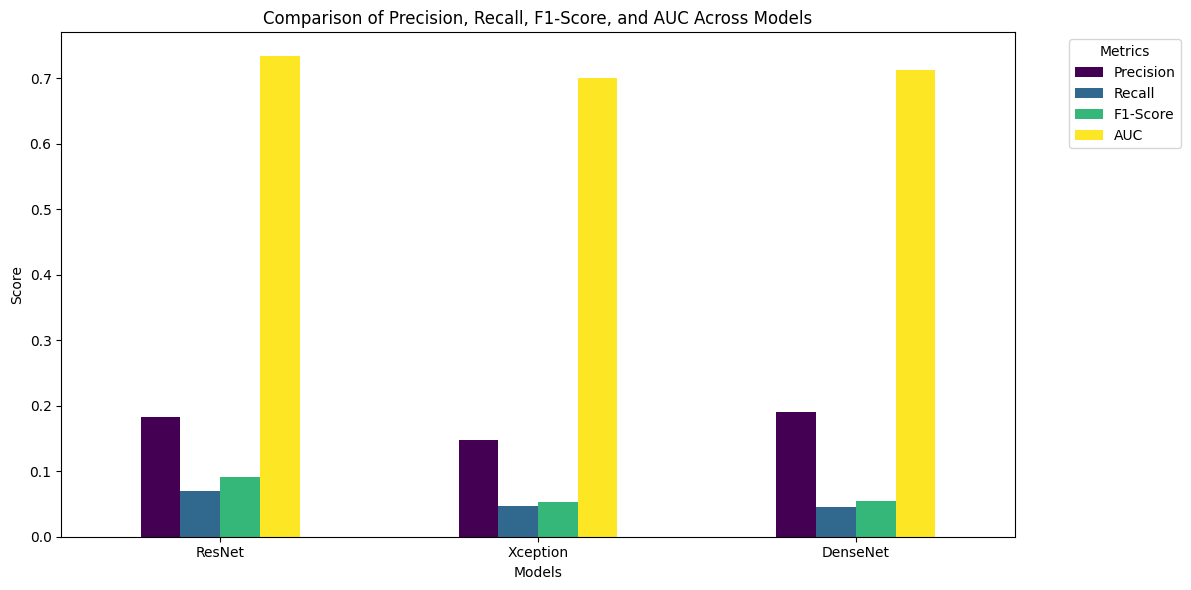

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

# Define function to compare models
def compare_models(models, histories, test_ds, class_names):
    
    # Accuracy and Loss Visualization
    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        plt.plot(history['accuracy'], label=f'{name} Training')
        plt.plot(history['val_accuracy'], label=f'{name} Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history['loss'], label=f'{name} Training')
        plt.plot(history['val_loss'], label=f'{name} Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Initialize comparison metrics
    comparison_metrics = {
        'Model': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'AUC': []
    }

    # Confusion Matrices and ROC Curves
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        y_true_all, y_pred_all = [], []
        
        # Collect predictions
        for images, labels in test_ds:
            predictions = model.predict(images, verbose=0)
            y_true_all.append(labels.numpy())
            y_pred_all.append(predictions)

        y_true = np.concatenate(y_true_all, axis=0)
        y_pred = np.concatenate(y_pred_all, axis=0)
        y_pred_binary = (y_pred > 0.5).astype(int)

        # Compute metrics
        precision = precision_score(y_true, y_pred_binary, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred_binary, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)

        # Compute AUC for each class and macro average
        auc_scores = []
        for i in range(len(class_names)):
            try:
                fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
                auc_scores.append(auc(fpr, tpr))
            except ValueError:
                auc_scores.append(0.5)  # Default to 0.5 if ROC can't be computed

        mean_auc = np.mean(auc_scores)

        # Append to metrics
        comparison_metrics['Model'].append(name)
        comparison_metrics['Precision'].append(precision)
        comparison_metrics['Recall'].append(recall)
        comparison_metrics['F1-Score'].append(f1)
        comparison_metrics['AUC'].append(mean_auc)

        # Confusion Matrix
        cm = confusion_matrix(y_true.argmax(axis=1), y_pred_binary.argmax(axis=1))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # ROC Curve
        plt.figure(figsize=(10, 8))
        for i, class_name in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc_scores[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.title(f'ROC Curve for {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

    # Summary Table
    summary_df = pd.DataFrame(comparison_metrics)
    print("\nModel Performance Comparison:")
    print(summary_df)

    # Bar Plot for Metrics
    summary_df.set_index('Model')[['Precision', 'Recall', 'F1-Score', 'AUC']].plot(kind='bar', figsize=(12, 6), colormap='viridis')
    plt.title('Comparison of Precision, Recall, F1-Score, and AUC Across Models')
    plt.ylabel('Score')
    plt.xlabel('Models')
    plt.xticks(rotation=0)
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example Usage
compare_models(
    models={'ResNet': resnet_model, 'Xception': xception_model, 'DenseNet': densenet_model},
    histories={
        'ResNet': history_resnet.history,
        'Xception': history_xception.history,
        'DenseNet': history_densenet.history
    },
    test_ds=test_ds,
    class_names=mlb.classes_
)


In [76]:
dummy_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'] # taken from paper

for label in dummy_labels:
    xray_data[label] = xray_data['Finding Labels'].map(lambda result: 1.0 if label in result else 0)
xray_data.head(20)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


(<Axes: xlabel='None', ylabel='0'>,
 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [Text(0, 0, 'Infiltration'),
   Text(1, 0, 'Effusion'),
   Text(2, 0, 'Atelectasis'),
   Text(3, 0, 'Nodule'),
   Text(4, 0, 'Mass'),
   Text(5, 0, 'Pneumothorax'),
   Text(6, 0, 'Consolidation'),
   Text(7, 0, 'Pleural_Thickening'),
   Text(8, 0, 'Cardiomegaly'),
   Text(9, 0, 'Emphysema'),
   Text(10, 0, 'Edema'),
   Text(11, 0, 'Fibrosis'),
   Text(12, 0, 'Pneumonia'),
   Text(13, 0, 'Hernia')]))

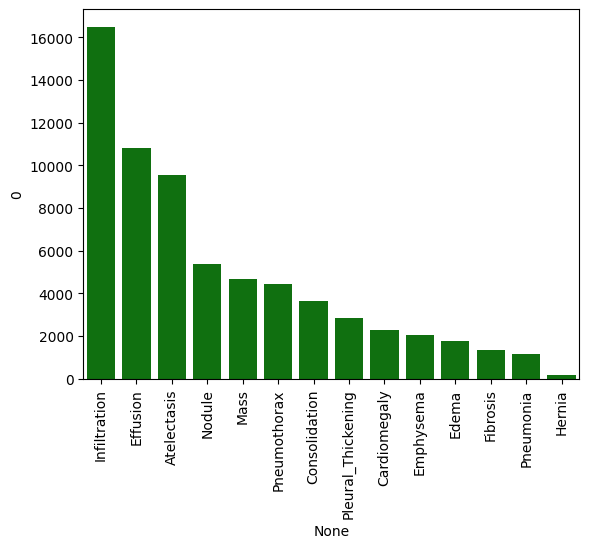

In [77]:
clean_labels = xray_data[dummy_labels].sum().sort_values(ascending= False)
clean_labels_df = clean_labels.to_frame()
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90)

In [86]:
print('training set - # of observations: ', len(train_df))
print('validation set - # of observations): ', len(val_df))
print('test set - # of observations): ', len(test_df))
print('prior, full data set - # of observations): ', len(xray_data))

training set - # of observations:  57056
validation set - # of observations):  14265
test set - # of observations):  20799
prior, full data set - # of observations):  92120


In [89]:
resnet_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_9 (Cast)       │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │      9,472 │ cast_9[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │      4,160 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add_12[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │      4,160 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │      4,160 │ re_lu_3[0][0]   

 Total params: 8,919,731 (34.03 MB)

 Trainable params: 2,970,639 (11.33 MB)

 Non-trainable params: 7,808 (30.50 KB)

 Optimizer params: 5,941,284 (22.66 MB)

In [90]:
xception_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_10 (Cast)      │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ cast_10[0][0]     │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_44 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0

 Total params: 24,031,835 (91.67 MB)

 Trainable params: 1,056,783 (4.03 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 2,113,572 (8.06 MB)

In [91]:
densenet_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_11 (Cast)      │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ cast_11[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b

 Total params: 8,634,995 (32.94 MB)

 Trainable params: 532,495 (2.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 1,064,996 (4.06 MB)